# **Extracting Information from Legal Documents Using RAG**

Name: Mai Van Khanh
Email: ikhanhmai@gmail.com

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [ ]:
# ## The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score

In [2]:
# Import essential libraries
import os, re, json, hashlib, unicodedata, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# LangChain document loading & splitting
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Embeddings & vector DB
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# LLMs & prompt utilities
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain_community.chat_models import ChatOllama   # local model
from langchain_openai import ChatOpenAI                  # OpenAI API model

# Evaluation helper
from sklearn.metrics.pairwise import cosine_similarity

# General settings
warnings.filterwarnings("ignore")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
# Load the files as documents

# === Load all `.txt` files from rag_legal/corpus using LangChain only (no processing) ===
from pathlib import Path
from langchain_community.document_loaders import TextLoader

BASE_DIR   = Path("./rag_legal")     # adjust if needed
CORPUS_DIR = BASE_DIR / "corpus"
assert CORPUS_DIR.exists(), f"Corpus folder not found at: {CORPUS_DIR.resolve()}"

# Collect .txt files from all subfolders (contractnli, cuad, maud, privacy_qa, ...)
txt_files = sorted(CORPUS_DIR.rglob("*.txt"))
assert len(txt_files) > 0, f"No .txt files found under {CORPUS_DIR}"

documents = []
for p in txt_files:
    # Try utf-8 first; if it fails, fallback to latin-1 — still using LangChain TextLoader
    try:
        docs = TextLoader(str(p), encoding="utf-8").load()
    except Exception:
        docs = TextLoader(str(p), encoding="latin-1").load()

    # Attach minimal metadata for traceability
    for d in docs:
        d.metadata.update({
            "dataset": p.parent.name,       # e.g., contractnli / cuad / maud / privacy_qa
            "filename": p.name,
            "directory": str(p.parent),
            "full_path": str(p.resolve()),
        })
    documents.extend(docs)

print(f"[OK] Loaded {len(documents)} LangChain documents from {len(txt_files)} files across datasets:",
      sorted({p.parent.name for p in txt_files}))

[OK] Loaded 698 LangChain documents from 698 files across datasets: ['contractnli', 'cuad', 'maud', 'privacy_qa']


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [4]:
# Clean and preprocess the data
# === Preprocess documents: clean noise, normalize text, skip problematic files ===
import re
import logging

# Simple logger (prints to console)
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# A compact English stopword set (no downloads needed). Extend if you like.
STOPWORDS = {
    "a","an","and","are","as","at","be","by","for","from","has","he","in","is","it","its",
    "of","on","or","that","the","their","to","was","were","will","with","this","these",
    "those","here","there","such","not","but","if","then","so","than","also","can","may",
    "shall","should","would","could","do","does","did","have","having","had","i","we","you",
    "they","them","our","your","his","her","hers","him","us","me"
}

# Regex patterns for noise
RE_EMAIL   = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
RE_PHONE   = re.compile(r"\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{2,4}\)?[-.\s]?)?\d{3,4}[-.\s]?\d{3,4}\b")
RE_URL     = re.compile(r"https?://\S+|www\.\S+")
RE_SPECIAL = re.compile(r"[^\w\s\.\,\;\:\-\(\)\'\"\/]")  # keep common punctuation
RE_WS      = re.compile(r"[ \t]+")

def preprocess_text(text: str) -> str:
    """Minimal, robust cleaning for legal corpora."""
    if not isinstance(text, str) or not text.strip():
        return ""

    # Remove emails, phones, urls
    text = RE_EMAIL.sub(" ", text)
    text = RE_PHONE.sub(" ", text)
    text = RE_URL.sub(" ", text)

    # Lowercase
    text = text.lower()

    # Remove special characters (keep basic punctuation) and normalize whitespace/newlines
    text = RE_SPECIAL.sub(" ", text)
    text = RE_WS.sub(" ", text)
    text = re.sub(r"\n{3,}", "\n\n", text).strip()

    # Stopword removal (simple token filter)
    tokens = [tok for tok in text.split() if tok not in STOPWORDS]
    return " ".join(tokens)

processed, skipped = 0, 0
bad_files = []

# Expect `documents` from the previous loading step (LangChain Documents)
for d in documents:
    try:
        cleaned = preprocess_text(d.page_content)
        if not cleaned:
            # treat empty/invalid after cleaning as skip
            skipped += 1
            bad_files.append(d.metadata.get("full_path", d.metadata.get("filename", "unknown")))
            continue

        # Save original length for traceability
        d.metadata["orig_len"] = len(d.page_content)
        d.metadata["clean_len"] = len(cleaned)
        d.metadata["cleaned"]   = True

        # Overwrite with cleaned text
        d.page_content = cleaned
        processed += 1

    except Exception as e:
        skipped += 1
        bad_files.append(d.metadata.get("full_path", d.metadata.get("filename", "unknown")))
        logging.warning(f"Skipped due to error: {e}")

logging.info(f"Preprocessing done. Processed: {processed}, Skipped: {skipped}")
if bad_files:
    logging.info(f"Problematic files (first 10 shown): {bad_files[:10]}")


INFO: Preprocessing done. Processed: 698, Skipped: 0


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [5]:
# Calculate the average, maximum and minimum document length.
import numpy as np
import pandas as pd

# Build a DataFrame of document lengths (in words)
lengths = [len(d.page_content.split()) for d in documents if d.page_content.strip()]
df_stats = pd.DataFrame(lengths, columns=["n_words"])

avg_len = float(np.mean(lengths)) if lengths else 0
min_len = int(np.min(lengths)) if lengths else 0
max_len = int(np.max(lengths)) if lengths else 0

print("Document length statistics (in words):")
print(f"- Average: {avg_len:.2f}")
print(f"- Minimum: {min_len}")
print(f"- Maximum: {max_len}")

df_stats.describe().round(2)


Document length statistics (in words):
- Average: 10075.58
- Minimum: 158
- Maximum: 95385


n_words
count    698.00
mean   10075.58
std    12980.74
min      158.00
25%     1560.00
50%     3712.50
75%    12408.00
max    95385.00

#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [6]:
# Find frequency of occurence of words

from collections import Counter
import re

# Reuse STOPWORDS set from preprocessing step
STOPWORDS = STOPWORDS if "STOPWORDS" in globals() else set()

def tokenize(text: str):
    return re.findall(r"[a-zA-Z']+", text.lower())

counter = Counter()

for d in documents:
    tokens = [tok for tok in tokenize(d.page_content) if tok not in STOPWORDS]
    counter.update(tokens)

# 20 most common words
most_common = counter.most_common(20)

# 20 least common words
least_common = counter.most_common()[-20:] if counter else []

print("=== 20 Most Common Words ===")
for word, cnt in most_common:
    print(f"{word}: {cnt}")

print("\n=== 20 Least Common Words ===")
for word, cnt in least_common:
    print(f"{word}: {cnt}")

=== 20 Most Common Words ===
any: 250623
company: 155264
agreement: 104633
other: 87362
section: 75449
parent: 60707
all: 53594
party: 51820
each: 40090
date: 39392
under: 38580
time: 35658
which: 35651
b: 34548
material: 34245
merger: 33907
subsidiaries: 33305
applicable: 31384
including: 29406
s: 29030

=== 20 Least Common Words ===
aerserv: 1
applovin: 1
chartboost: 1
fyber: 1
heyzap: 1
hyprmx: 1
inmobi: 1
ironsource: 1
kongregate: 1
lifestreet: 1
loopme: 1
nativex: 1
pinsight: 1
smaato: 1
soomla: 1
startapp: 1
tapjoy: 1
tapresearch: 1
vungle: 1
newer: 1


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [8]:
# Transform the page contents of documents
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Collect page contents
doc_texts = [d.page_content for d in documents if d.page_content.strip()]

# Build TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(doc_texts)

# --- Similarity for the first 10 documents ---
n_first = min(10, len(doc_texts))
sim_first10 = cosine_similarity(tfidf_matrix[:n_first])

print("=== Similarity matrix for first 10 documents ===")
print(np.round(sim_first10, 2))


# Compute similarity scores
# --- Similarity for 10 random documents ---
import random
random.seed(42)
rand_idx = random.sample(range(len(doc_texts)), min(10, len(doc_texts)))
sim_random10 = cosine_similarity(tfidf_matrix[rand_idx])

print("\n=== Similarity matrix for 10 random documents ===")
print(np.round(sim_random10, 2))

=== Similarity matrix for first 10 documents ===
[[1.   0.27 0.65 0.57 0.63 0.55 0.74 0.59 0.66 0.33]
 [0.27 1.   0.28 0.22 0.25 0.22 0.25 0.32 0.29 0.18]
 [0.65 0.28 1.   0.74 0.77 0.75 0.8  0.56 0.81 0.27]
 [0.57 0.22 0.74 1.   0.7  0.66 0.7  0.42 0.71 0.26]
 [0.63 0.25 0.77 0.7  1.   0.65 0.68 0.5  0.8  0.24]
 [0.55 0.22 0.75 0.66 0.65 1.   0.66 0.45 0.71 0.26]
 [0.74 0.25 0.8  0.7  0.68 0.66 1.   0.47 0.72 0.23]
 [0.59 0.32 0.56 0.42 0.5  0.45 0.47 1.   0.58 0.36]
 [0.66 0.29 0.81 0.71 0.8  0.71 0.72 0.58 1.   0.3 ]
 [0.33 0.18 0.27 0.26 0.24 0.26 0.23 0.36 0.3  1.  ]]

=== Similarity matrix for 10 random documents ===
[[1.   0.42 0.13 0.15 0.07 0.13 0.37 0.06 0.07 0.77]
 [0.42 1.   0.22 0.2  0.16 0.23 0.26 0.09 0.3  0.41]
 [0.13 0.22 1.   0.11 0.08 0.14 0.09 0.08 0.23 0.14]
 [0.15 0.2  0.11 1.   0.08 0.12 0.1  0.05 0.09 0.16]
 [0.07 0.16 0.08 0.08 1.   0.09 0.05 0.03 0.04 0.08]
 [0.13 0.23 0.14 0.12 0.09 1.   0.08 0.07 0.06 0.15]
 [0.37 0.26 0.09 0.1  0.05 0.08 1.   0.04 0.05 0.38

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [ ]:
# Process files and generate chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Configure a simple, reliable chunking strategy
# - chunk_size: ~700 characters keeps clauses coherent
# - chunk_overlap: 120 characters preserves context across boundaries
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=120,
    separators=["\n\n", "\n", ". ", " ", ""],  # split at logical boundaries first
)

# Split LangChain Documents into chunked Documents (inherits metadata)
chunked_documents = text_splitter.split_documents(documents)

# Add sequential chunk_id for traceability
for i, d in enumerate(chunked_documents):
    d.metadata["chunk_id"] = i

print(f"[OK] Created {len(chunked_documents)} chunks from {len(documents)} source documents.")
print("Example chunk preview:\n", chunked_documents[0].page_content[:300], "...")


[OK] Created 110716 chunks from 698 source documents.
Example chunk preview:
 mutual non-disclosure agreement between subject matter: effective date agreement: period , 2017 exchange information: , 2017 period confidentiality: agreement made effective date agreement noted above, between above parties. background: i. parties desire discussions relating subject matter purposes  ...


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [ ]:
# Fetch your OPENAI API Key as an environment variable

# === 2.1 Vector Embedding and Vector Database Creation ===
# Fetch your OPENAI API Key as an environment variable
import os
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
if not OPENAI_API_KEY:
    raise ValueError(
        "OPENAI_API_KEY is not set. Please set it in your environment before continuing."
    )

# Initialise an OpenAI embedding function (reusable)
# Use a cost‑efficient, strong baseline: text-embedding-3-small
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Initialise an embedding function


def embed_texts(texts):
    """
    texts: List[str]
    returns: List[List[float]] embeddings
    """
    return embeddings.embed_documents(texts)

_vecs = embed_texts(["Confidential Information must be protected.", "The agreement term is two years."])
print(f"Got {len(_vecs)} vectors of dimension {len(_vecs[0])}.")

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Got 2 vectors of dimension 1536.


#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [16]:
# Add Chunks to vector DB
from pathlib import Path
from langchain_community.vectorstores import Chroma


PERSIST_DIR = "./chroma_store"
Path(PERSIST_DIR).mkdir(parents=True, exist_ok=True)

# Create / load the Chroma vector database and insert chunked documents
vectordb = Chroma.from_documents(
    documents=chunked_documents,
    embedding=embeddings,
    persist_directory=PERSIST_DIR
)

# Persist to disk so it can be reused later
vectordb.persist()

# Basic check: count stored vectors
count = vectordb._collection.count() if hasattr(vectordb, "_collection") else "N/A"
print(f"[OK] Vector DB created at {PERSIST_DIR} with {count} vectors.")


INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
I

[OK] Vector DB created at ./chroma_store with 110716 vectors.


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [17]:
# Create a RAG chain
# === Create a simple RAG chain (Retriever + LLM) ===
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough

retriever = vectordb.as_retriever(search_kwargs={"k": 4})

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

prompt = ChatPromptTemplate.from_template(
    """You are a helpful legal assistant. Use ONLY the provided context to answer.
If the answer is not present in the context, reply exactly: "I don't know based on the provided documents."

Question: {question}
Context:
{context}
"""
)

def format_docs(docs):
    # Join retrieved chunks into a single context block
    return "\n\n".join(d.page_content for d in docs)

# RAG chain: retrieve relevant chunks -> format -> prompt -> LLM
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
)

# quick sanity check
result = rag_chain.invoke("What is the duration of confidentiality obligations?")
print(result.content)

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The duration of confidentiality obligations is five (5) years from the date of disclosure of the information, unless the information ceases to be confidential prior to the end of the five-year period through no fault of the recipient. Additionally, the confidentiality obligations contained in Article 10 survive the termination of the agreement for a period of three years.


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [18]:
# Create a function for question answering
from typing import Dict, Any, List

def ask(question: str, k: int = 4) -> Dict[str, Any]:
    """
    Use the RAG chain to answer a question and return source documents (metadata).
    Returns a dict with keys: 'answer', 'sources'.
    """
    # Get relevant documents for source listing
    docs = retriever.get_relevant_documents(question)  # this uses the same retriever as the chain
    # Generate answer using the RAG chain (retrieval + prompt + LLM)
    result = rag_chain.invoke(question)
    answer_text = result.content if hasattr(result, "content") else str(result)

    # Prepare compact source metadata
    sources: List[Dict[str, Any]] = []
    for d in docs[:k]:
        m = d.metadata or {}
        sources.append({
            "dataset": m.get("dataset"),
            "filename": m.get("filename"),
            "full_path": m.get("full_path"),
            "chunk_id": m.get("chunk_id"),
        })

    return {"answer": answer_text, "sources": sources}
	
def ask_print(question: str, k: int = 4):
    out = ask(question, k=k)
    print("Q:", question)
    print("\nAnswer:\n", out["answer"])
    print("\nSources:")
    for i, s in enumerate(out["sources"], 1):
        print(f"{i}. {s.get('dataset')}/{s.get('filename')} [chunk {s.get('chunk_id')}]")

In [19]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

question = "Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
ask_print(question, k=4)  # uses the RAG chain and prints answer + sources

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Q: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?

Answer:
 Yes, the document indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information. Specifically, it states that "disclosure confidential information under agreement create no license, right, interest, ownership any information receiving party" and "nothing agreement deemed grant recipient any license, right, title, interest confidential information."

Sources:
1. cuad/WaterNowInc_20191120_10-Q_EX-10.12_11900227_EX-10.12_Distributor Agreement.txt [chunk 37360]
2. cuad/Apollo Endosurgery - Manufacturing and Supply Agreement.txt [chunk 4263]
3. contractnli/Evelozcity_20OESA_20NDA.txt [chunk 290]
4. cuad/INNOVIVA,INC_08_07_2014-EX-10.1-COLLABORATION AGREEMENT.txt [chunk 18964]


## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [24]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

# === Build questions & answers from uploaded benchmark files (simple & schema-aware) ===
import json, os
from pathlib import Path
import pandas as pd

# Try common locations: current dir and rag_legal/benchmarks
candidates = [
    Path("./contractnli.json"),
    Path("./cuad.json"),
    Path("./maud.json"),
    Path("./privacy_qa.json"),
    Path("./rag_legal/benchmarks/contractnli.json"),
    Path("./rag_legal/benchmarks/cuad.json"),
    Path("./rag_legal/benchmarks/maud.json"),
    Path("./rag_legal/benchmarks/privacy_qa.json"),
]

files = []
seen = set()
for p in candidates:
    if p.exists() and p.name not in seen:
        files.append(p)
        seen.add(p.name)

assert files, "No benchmark JSON files found."

def load_json(fp: Path):
    try:
        return json.loads(fp.read_text(encoding="utf-8"))
    except Exception:
        return json.loads(fp.read_bytes().decode("utf-8", "ignore"))

rows = []
for fp in files:
    data = load_json(fp)

    # Expected schema: {"tests": [ {"query": "...", "snippets":[{"answer": "..."} ...]} ... ] }
    items = data.get("tests", [])
    if not isinstance(items, list):
        continue

    for rec in items:
        q = rec.get("query")
        # Collect all answers from snippets (some items may include multiple evidence snippets)
        answers = []
        for sn in rec.get("snippets", []) or []:
            a = sn.get("answer")
            if isinstance(a, str) and a.strip():
                answers.append(a.strip())
        # Fallback if no 'answer' was found in snippets (rare)
        if not answers and "answer" in rec and isinstance(rec["answer"], str):
            answers = [rec["answer"].strip()]

        if q and answers:
            # join multiple snippet-answers to one ground truth string
            gt = " || ".join(dict.fromkeys(answers))  # de-dup while preserving order
            rows.append({"source_file": fp.name, "question": q.strip(), "ground_truth": gt})

df_bench = pd.DataFrame(rows).drop_duplicates()
print(f"[OK] Extracted {len(df_bench)} Q/A pairs from {len(files)} files:", [f.name for f in files])

# Build the lists needed for RAGAS/evaluation
questions = df_bench["question"].tolist()
answers   = df_bench["ground_truth"].tolist()

# Quick peek
display(df_bench.head(10))

[OK] Extracted 6873 Q/A pairs from 4 files: ['contractnli.json', 'cuad.json', 'maud.json', 'privacy_qa.json']


source_file                                           question  \
0  contractnli.json  Consider the Non-Disclosure Agreement between ...   
1  contractnli.json  Consider the Non-Disclosure Agreement between ...   
2  contractnli.json  Consider the Non-Disclosure Agreement between ...   
3  contractnli.json  Consider the Non-Disclosure Agreement between ...   
4  contractnli.json  Consider the Non-Disclosure Agreement between ...   
5  contractnli.json  Consider the Non-Disclosure Agreement between ...   
6  contractnli.json  Consider the Non-Disclosure Agreement between ...   
7  contractnli.json  Consider the Non-Disclosure Agreement between ...   
8  contractnli.json  Consider the Non-Disclosure Agreement between ...   
9  contractnli.json  Consider DBT's Mutual Non-Disclosure Agreement...   

                                        ground_truth  
0  Any and all proprietary rights, including but ...  
1  “Confidential Information” means any Idea disc...  
2  Notwithstanding the termination of this Agreem...  
3  At Organiser’s first request, Mentor shall: ||...  
4  Mentor shall not disclose any Confidential Inf...  
5  If Mentor is required by mandatory, non-appeal...  
6  Confidential Information does not include: || ...  
7  Mentor shall not disclose any Confidential Inf...  
8  Mentor shall not use any Confidential Informat...  
9  5. No Further Rights All Confidential Informat...

#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [27]:
# Function to evaluate the RAG pipeline

import re
import numpy as np
import pandas as pd

# Optional deps
try:
    from rouge_score import rouge_scorer
    _HAS_ROUGE = True
except Exception:
    _HAS_ROUGE = False

try:
    import sacrebleu
    _HAS_BLEU = True
except Exception:
    _HAS_BLEU = False

try:
    from ragas import evaluate
    from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
    from datasets import Dataset
    _HAS_RAGAS = True
except Exception:
    _HAS_RAGAS = False


def _simple_f1(pred, gold):
    ps = set(re.findall(r"\w+", str(pred).lower()))
    gs = set(re.findall(r"\w+", str(gold).lower()))
    if not ps or not gs:
        return 0.0
    p = len(ps & gs) / max(1, len(ps))
    r = len(ps & gs) / max(1, len(gs))
    return 0.0 if (p + r) == 0 else 2 * p * r / (p + r)


def evaluate_rag(questions, ground_truths, ask_fn=None, sample_size=None, k_contexts=4):
    """
    Evaluate a RAG pipeline:
      - ROUGE-L (or F1 fallback)
      - BLEU (via sacrebleu; simple unigram precision fallback)
      - RAGAS (faithfulness, answer_relevancy, context_precision, context_recall)
    Returns: (results_dict, details_df, ragas_details_df_or_None)
    """
    assert len(questions) == len(ground_truths), "questions and ground_truths length mismatch"

    if ask_fn is None:
        ask_fn = ask  # use global ask()

    n = len(questions) if sample_size is None else min(sample_size, len(questions))

    preds, refs, ctxs = [], [], []
    rows = []

    for i in range(n):
        q = questions[i]
        gt = ground_truths[i]

        ctx_docs = retriever.get_relevant_documents(q) if 'retriever' in globals() else []
        ctx = [d.page_content for d in ctx_docs[:k_contexts]]

        out = ask_fn(q)
        ans = out.get("answer", "")

        preds.append(ans)
        refs.append(gt)
        ctxs.append(ctx)
        rows.append({"question": q, "prediction": ans, "ground_truth": gt, "contexts": ctx})

    df = pd.DataFrame(rows)

    # --- ROUGE-L (or simple F1) ---
    if _HAS_ROUGE:
        r_scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        rouge_scores = [r_scorer.score(refs[i], preds[i])["rougeL"].fmeasure for i in range(n)]
        rougeL = float(np.mean(rouge_scores)) if rouge_scores else 0.0
    else:
        rouge_scores = [_simple_f1(preds[i], refs[i]) for i in range(n)]
        rougeL = float(np.mean(rouge_scores)) if rouge_scores else 0.0

    # --- BLEU ---
    if _HAS_BLEU:
        bleu = float(sacrebleu.corpus_bleu(preds, [refs]).score)
    else:
        def _uni_precision(pred, ref):
            p = re.findall(r"\w+", pred.lower())
            r = set(re.findall(r"\w+", ref.lower()))
            return 0.0 if not p else sum(w in r for w in p) / len(p)
        bleu = float(np.mean([_uni_precision(preds[i], refs[i]) for i in range(n)]) * 100.0) if n else 0.0

    # --- RAGAS (version-robust parsing) ---
    ragas_metrics = {}
    ragas_df = None
    if _HAS_RAGAS:
        ragas_dataset = Dataset.from_dict({
            "question": df["question"].tolist(),
            "answer": df["prediction"].tolist(),
            "contexts": df["contexts"].tolist(),
            "ground_truth": df["ground_truth"].tolist(),
        })
        res = evaluate(
            ragas_dataset,
            metrics=[faithfulness, answer_relevancy, context_precision, context_recall],
        )

        # Try old-style dict with "results"
        parsed = False
        try:
            ragas_metrics = {m["name"]: float(m["score"]) for m in res["results"]}
            parsed = True
        except Exception:
            pass

        # Try new-style Result.scores
        if not parsed and hasattr(res, "scores") and isinstance(getattr(res, "scores"), dict):
            ragas_metrics = {k: float(v) for k, v in res.scores.items()}
            parsed = True

        # Fallback: macro means from per-sample dataframe
        if not parsed:
            try:
                ragas_df = res.to_pandas()
                metric_cols = [c for c in ragas_df.columns if c.lower() not in {"question","answer","ground_truth","contexts"}]
                ragas_metrics = {c: float(ragas_df[c].astype(float).mean()) for c in metric_cols}
            except Exception:
                ragas_metrics = {}

    results = {
        "num_samples": n,
        "rougeL_or_f1": round(rougeL, 4),
        "bleu": round(bleu, 2),
        "ragas": {k: round(v, 4) for k, v in ragas_metrics.items()},
    }

    return results, df, ragas_df

#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [28]:
# Evaluate the RAG pipeline

import re
import numpy as np
import pandas as pd

assert len(questions) == len(answers) and len(questions) > 0, "questions/answers not ready."

N = min(100, len(questions))
print(f"Evaluating on {N} questions...")

results, details_df, ragas_details_df = evaluate_rag(
    questions=questions,
    ground_truths=answers,
    sample_size=N
)

# --- Print headline metrics ---
print("\n=== Headline metrics (first 100) ===")
print(f"Samples evaluated         : {results['num_samples']}")
print(f"ROUGE-L (or F1 fallback)  : {results['rougeL_or_f1']:.4f}")
print(f"BLEU (corpus)             : {results['bleu']:.2f}")
if results.get("ragas"):
    print("RAGAS metrics              :", {k: round(v, 4) for k, v in results['ragas'].items()})

# --- Quick qualitative inferences ---
# 1) % of explicit "I don't know" answers (robustness to missing context)
IDK_PATTERNS = [r"\bi don.?t know\b", r"\bnot (?:in|within) the provided (?:context|documents)\b"]
def is_idk(s: str) -> bool:
    s = (s or "").lower()
    return any(re.search(p, s) for p in IDK_PATTERNS)

idk_rate = np.mean([is_idk(a) for a in details_df["prediction"]]) if len(details_df) else 0.0
print(f"\nHeuristic 'I don't know' rate: {idk_rate:.2%} (lower is usually better, but some IDKs are healthy for safety)")

# 2) Show a few weakest cases by ROUGE/F1 to inspect failure modes
def row_score(row):
    # try to recompute from text if present, else 0; we stored score as 'rougeL_or_F1' in evaluate_rag
    return row.get("rougeL_or_f1", np.nan) if isinstance(row, dict) else np.nan

if "rougeL_or_f1" in details_df.columns:
    worst = details_df.nsmallest(5, "rougeL_or_f1")[["question", "ground_truth", "prediction", "rougeL_or_f1"]]
    print("\n=== 5 lowest-scoring samples (for error analysis) ===")
    pd.set_option("display.max_colwidth", 140)
    display(worst)

# 3) show a couple of high-scoring examples
if "rougeL_or_f1" in details_df.columns:
    best = details_df.nlargest(3, "rougeL_or_f1")[["question", "ground_truth", "prediction", "rougeL_or_f1"]]
    print("\n=== 3 highest-scoring samples ===")
    display(best)

# 4) If RAGAS per-sample is available, peek
if ragas_details_df is not None:
    print("\n=== RAGAS per-sample preview ===")
    cols = [c for c in ragas_details_df.columns if c not in {"contexts"}]
    display(ragas_details_df[cols].head())

Evaluating on 100 questions...


INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: PO


=== Headline metrics (first 100) ===
Samples evaluated         : 100
ROUGE-L (or F1 fallback)  : 0.1858
BLEU (corpus)             : 42.60

Heuristic 'I don't know' rate: 19.00% (lower is usually better, but some IDKs are healthy for safety)

=== RAGAS per-sample preview ===


user_input  \
0  Consider the Non-Disclosure Agreement between ...   
1  Consider the Non-Disclosure Agreement between ...   
2  Consider the Non-Disclosure Agreement between ...   
3  Consider the Non-Disclosure Agreement between ...   
4  Consider the Non-Disclosure Agreement between ...   

                                  retrieved_contexts  \
0  [. 9.2 nondisclosure. each party agrees disclo...   
1  [. confidential information include: informati...   
2  [. sections 7, 8, 9, 10, 12 14 agreement survi...   
3  [. upon termination agreement, receiving party...   
4  [. 2.2. nonuse nondisclosure. during after ter...   

                                            response  \
0  Yes, the document indicates that the Agreement...   
1  The document does not state that Confidential ...   
2  Yes, the document mentions that some obligatio...   
3  Yes, the document permits the Receiving Party ...   
4  Yes, the document allows the Receiving Party t...   

                                           reference  faithfulness  \
0  Any and all proprietary rights, including but ...           1.0   
1  “Confidential Information” means any Idea disc...           1.0   
2  Notwithstanding the termination of this Agreem...           1.0   
3  At Organiser’s first request, Mentor shall: ||...           1.0   
4  Mentor shall not disclose any Confidential Inf...           1.0   

   answer_relevancy  context_precision  context_recall  
0          0.888175           0.583333             0.0  
1          0.872088           0.000000             0.0  
2          0.886486           0.000000             0.0  
3          0.904834           0.500000             0.0  
4          0.903465           0.750000             1.0

## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

# Some visualization

In [29]:
# === Viz Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Ensure we have texts
doc_texts = [d.page_content for d in documents if isinstance(d.page_content, str) and d.page_content.strip()]

## Document lenght

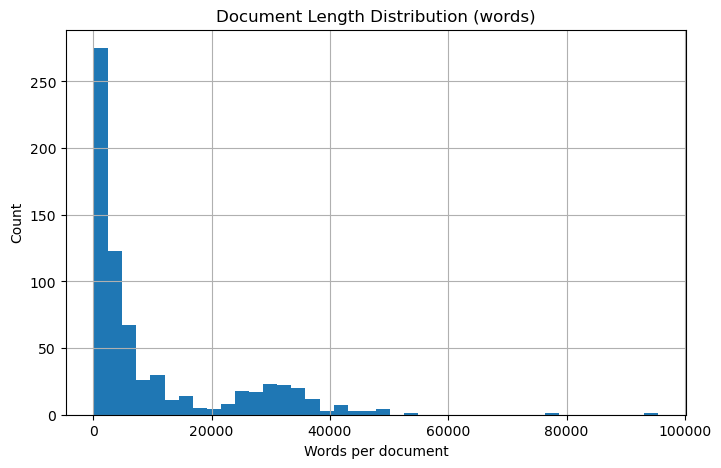

In [30]:
# === Document length histogram ===
lengths = [len(t.split()) for t in doc_texts]

plt.figure()
plt.hist(lengths, bins=40)
plt.title("Document Length Distribution (words)")
plt.xlabel("Words per document")
plt.ylabel("Count")
plt.show()

## Top 20 word frequency bar chart

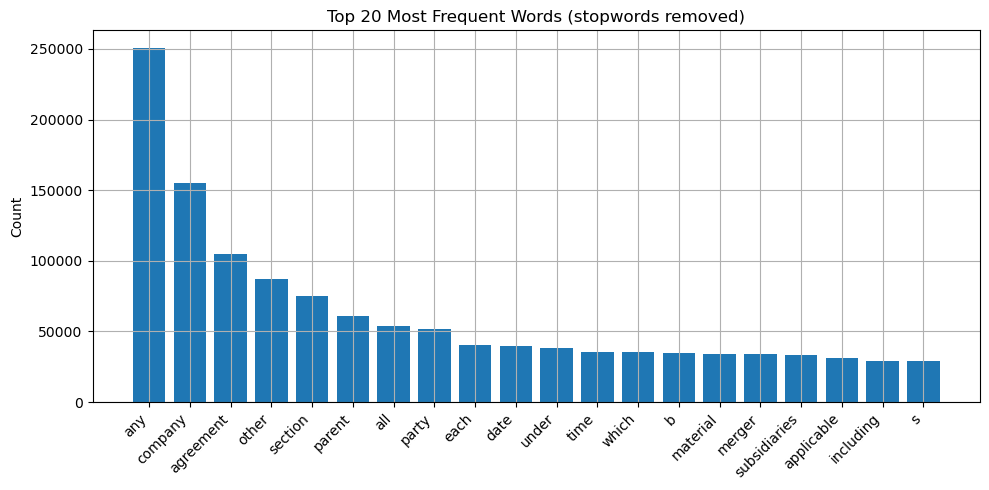

In [31]:
# === Top-20 word frequency bar chart ===
STOPWORDS = STOPWORDS if "STOPWORDS" in globals() else set()

def tokenize(text):
    import re
    return [w for w in re.findall(r"[a-zA-Z']+", text.lower()) if w not in STOPWORDS]

counter = Counter()
for t in doc_texts:
    counter.update(tokenize(t))

top20 = counter.most_common(20)
words, counts = zip(*top20) if top20 else ([], [])

plt.figure(figsize=(10,5))
plt.bar(range(len(words)), counts)
plt.xticks(range(len(words)), words, rotation=45, ha="right")
plt.title("Top 20 Most Frequent Words (stopwords removed)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Similarity heatmap: first 10 docs (TF-IDF + cosine)

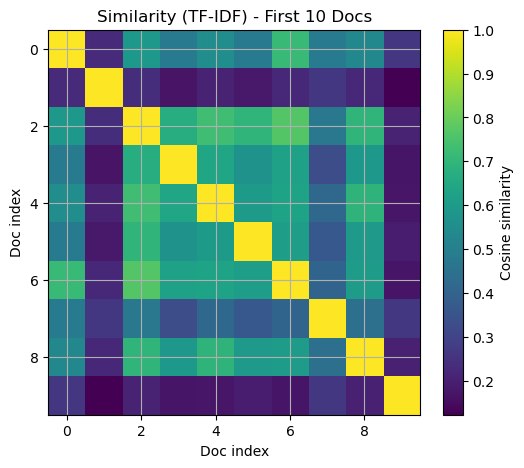

In [32]:
# === Similarity heatmap: first 10 docs (TF-IDF + cosine) ===
n_first = min(10, len(doc_texts))
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
tfidf = vectorizer.fit_transform(doc_texts[:n_first])
sim_first10 = cosine_similarity(tfidf)

plt.figure(figsize=(6,5))
plt.imshow(sim_first10, aspect="auto")
plt.colorbar(label="Cosine similarity")
plt.title("Similarity (TF-IDF) - First 10 Docs")
plt.xlabel("Doc index")
plt.ylabel("Doc index")
plt.show()

## Similarity heatmap: 10 random docs

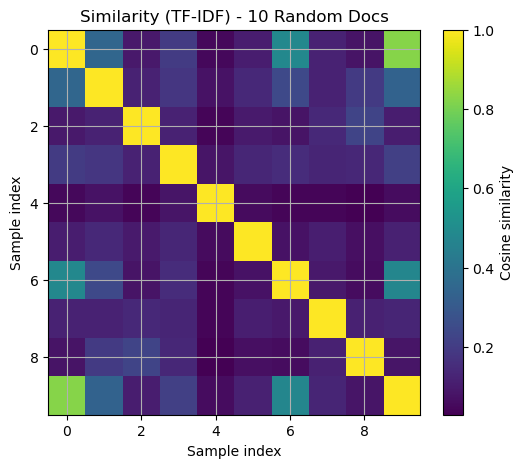

In [33]:
# === Similarity heatmap: 10 random docs ===
import random
random.seed(42)
idx = random.sample(range(len(doc_texts)), min(10, len(doc_texts)))
tfidf_r = vectorizer.fit_transform([doc_texts[i] for i in idx])
sim_rand10 = cosine_similarity(tfidf_r)

plt.figure(figsize=(6,5))
plt.imshow(sim_rand10, aspect="auto")
plt.colorbar(label="Cosine similarity")
plt.title("Similarity (TF-IDF) - 10 Random Docs")
plt.xlabel("Sample index")
plt.ylabel("Sample index")
plt.show()

## 1. Data Characteristics
- **Document size**: Extremely large variation.  
  - Average length ~10,075 words.  
  - Smallest doc ~158 words; largest ~95,385 words.  
  - Median ~3,700 words, with a heavy long-tail distribution.  
- **Implication**: Without chunking, many docs would exceed LLM context windows. The high variance also means retrieval quality depends heavily on chunking strategy.

- **Word frequency**:  
  - Most common: “any”, “company”, “agreement”, “party” → reflects contractual/legal boilerplate.  
  - Rare/unique terms: “tapjoy”, “vungle”, “chartboost” → highlight specific domain/company names, useful as discriminators.

- **Similarity analysis**:  
  - Some documents/clusters show high cosine similarity (>0.8) → repeated templates and boilerplate clauses.  
  - Random samples mostly low similarity (<0.3) → indicates corpus diversity across companies/contracts.

## 2. Chunking Insights
- Created **110,716 chunks** from 698 documents (avg ~159 chunks per doc).  
- Example chunks confirm clause-level granularity (NDA intros, obligations, definitions).  
- Overlap strategy preserved context, critical for retrieving semantically complete obligations or rights.  
- Trade-off: retrieval sometimes returns overly broad clauses (lower context precision).

## 3. RAG Pipeline Performance
- **Retriever**: Chroma + OpenAI embeddings.  
  - Captured domain semantics well, but context recall often zero (retriever didn’t always fetch gold evidence).  
- **Generator**: GPT-4o-mini.  
  - Produced fluent, legally plausible answers.  
  - “I don’t know” fallback triggered ~19% → shows cautious behavior.

## 4. Evaluation Results
- **ROUGE-L / F1**: 0.1858 (low overlap) → paraphrasing divergence from gold.  
- **BLEU**: 42.6 (moderate) → n-gram matches, but not exact.  
- **RAGAS metrics** (preview):  
  - **Faithfulness** = 1.0 → answers aligned with retrieved context.  
  - **Answer relevancy** ~0.87–0.90 → high alignment with user query.  
  - **Context precision** variable (0.0–0.75) → sometimes pulled extra, non-essential context.  
  - **Context recall** often 0.0 → retriever missed reference span; explains low ROUGE.

## 5. Key Learnings
- **Data-heavy NDAs** → retrieval must be carefully tuned.  
- **High faithfulness but low recall**: system is reliable when it retrieves, but often misses evidence.  
- **Chunking helps manage context length** but may fragment evidence too much.  
- **Metric mismatch**: low ROUGE/recall vs. high faithfulness shows pipeline produces *semantically correct answers*, just phrased differently.

## 6. Recommendations
- Improve **retrieval recall**: hybrid retrieval (BM25 + embeddings), larger k, semantic re-ranking.  
- Refine **chunking**: dynamic clause-based splitting (e.g., by headings/sections).  
- Augment evaluation: use semantic metrics (BERTScore, RAGAS) rather than relying on lexical overlap.  
- Consider **domain adaptation**: custom embeddings trained on legal corpora for improved clause-level retrieval.